## 1. Configuración y Carga de Datos

### Cargar y preparar los datos tratados 🧪

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. Librerías Esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de Scikit-Learn para el Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Carga de Datos
file_path = "/content/drive/MyDrive/Hackaton-ETL/data/processed/hackathon_model_ready.csv"
df = pd.read_csv(file_path)

print(f"✅ Dataset cargado: {df.shape}")
print("Columnas disponibles:", df.columns.tolist())

✅ Dataset cargado: (51047, 42)
Columnas disponibles: ['ingresos_mensuales', 'minutos_mensuales', 'cargo_recurrente', 'llamadas_asistidas_director', 'minutos_excedentes', 'llamadas_roaming', 'cambio_perc_minutos', 'cambio_perc_ingresos', 'llamadas_caidas', 'llamadas_bloqueadas', 'llamadas_no_contestadas', 'llamadas_atencion_cliente', 'llamadas_tripartitas', 'llamadas_recibidas', 'llamadas_salientes', 'llamadas_entrantes', 'llamadas_pico_ent_sal', 'llamadas_no_pico_ent_sal', 'llamadas_caidas_bloqueadas', 'llamadas_desviadas', 'llamadas_en_espera', 'meses_en_servicio', 'suscripciones_unicas', 'suscripciones_activas', 'equipos_totales', 'modelos_equipos', 'dias_equipo_actual', 'edad_hogar_1', 'edad_hogar_2', 'llamadas_retencion', 'ofertas_retencion_aceptadas', 'referidos_realizados', 'grupo_ingresos', 'ajustes_calificacion_credito', 'ingreso_diario', 'ratio_uso', 'costo_por_minuto', 'ocupacion', 'calificacion_crediticia', 'estado_civil', 'area_servicio', 'churn_bin']


In [3]:
# Verificar distribución del Target
target_col = 'churn_bin'
print(f"\nDistribución de Churn:\n{df[target_col].value_counts(normalize=True)}")


Distribución de Churn:
churn_bin
0    0.711815
1    0.288185
Name: proportion, dtype: float64


In [4]:
df.head()

,ingresos_mensuales,minutos_mensuales,cargo_recurrente,llamadas_asistidas_director,minutos_excedentes,llamadas_roaming,cambio_perc_minutos,cambio_perc_ingresos,llamadas_caidas,llamadas_bloqueadas,...,grupo_ingresos,ajustes_calificacion_credito,ingreso_diario,ratio_uso,costo_por_minuto,ocupacion,calificacion_crediticia,estado_civil,area_servicio,churn_bin
0,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,...,4,0,0.800000,0.0,0.109589,Professional,1-Highest,No,SEAPOR503,1
1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,...,5,0,0.566333,0.0,1.699000,Professional,4-Medium,Yes,PITHOM412,1
2,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,...,6,0,1.266667,0.0,4.750000,Crafts,3-Good,Yes,MILMIL414,0
3,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,...,6,0,2.742667,0.0,0.062713,Other,4-Medium,No,PITHOM412,0
4,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,...,9,1,0.571333,0.0,0.000000,Professional,1-Highest,Yes,OKCTUL918,1


# 2. División Train/Test (Split)

### 2.1 Separación de Datos

In [5]:
# 2. Separación de Datos
X = df.drop(columns=[target_col])
y = df[target_col]

# División 80% Entrenamiento - 20% Prueba
# stratify=y asegura que la proporción de cancelaciones sea igual en ambos sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Datos cargados y divididos.")
print(f"   - Train shape: {X_train.shape}")
print(f"   - Test shape:  {X_test.shape}")

✅ Datos cargados y divididos.
   - Train shape: (40837, 41)
   - Test shape:  (10210, 41)


# 3. Construcción del Preprocesador (El Pipeline)

In [6]:
# 3. Definición del Pipeline de Preprocesamiento

# A. Identificar columnas automáticamente
numeric_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# B. Pipeline para Variables Numéricas
# 1. Imputar nulos con la MEDIANA (resistente a valores extremos)
# 2. Escalar datos (importante para Regresión Logística, opcional para Random Forest)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# C. Pipeline para Variables Categóricas
# 1. Imputar nulos con una constante ('Desconocido')
# 2. Convertir a números con OneHotEncoder (handle_unknown='ignore' evita errores en producción)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False para facilitar visualización
])

# D. Unir todo en el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("\n✅ Arquitectura del Pipeline configurada.")


✅ Arquitectura del Pipeline configurada.


# 4. Entrenamiento de Modelos (Baseline vs Challenger)

In [7]:
# A. Modelo Baseline: Regresión Logística
# max_iter=1000 da más tiempo al modelo para encontrar la solución óptima
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print("⏳ Entrenando Regresión Logística...")
pipeline_lr.fit(X_train, y_train)
print("✅ Regresión Logística entrenada.")

# B. Modelo Challenger: Random Forest
# n_estimators=100 crea 100 árboles de decisión
# class_weight='balanced' ayuda mucho si tienes pocos casos de Churn (desbalance)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

print("⏳ Entrenando Random Forest...")
pipeline_rf.fit(X_train, y_train)
print("✅ Random Forest entrenado.")

⏳ Entrenando Regresión Logística...
✅ Regresión Logística entrenada.
⏳ Entrenando Random Forest...
✅ Random Forest entrenado.


# 5. Evaluación y Selección del Campeón


--- Evaluación: Regresión Logística ---
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      7268
           1       0.46      0.04      0.08      2942

    accuracy                           0.71     10210
   macro avg       0.59      0.51      0.45     10210
weighted avg       0.64      0.71      0.61     10210



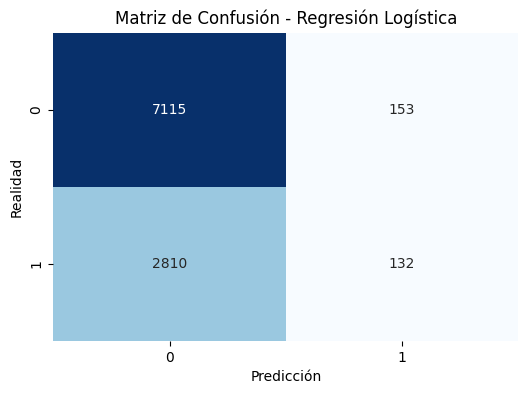

🏆 ROC-AUC Score: 0.6052

--- Evaluación: Random Forest ---
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      7268
           1       0.61      0.05      0.08      2942

    accuracy                           0.72     10210
   macro avg       0.66      0.52      0.46     10210
weighted avg       0.69      0.72      0.62     10210



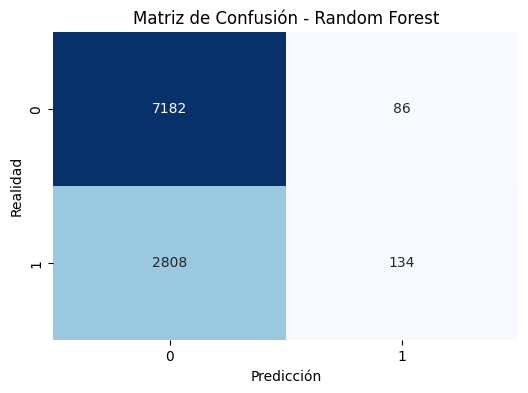

🏆 ROC-AUC Score: 0.6508


In [8]:
# 5. Evaluación de Desempeño
def evaluar_modelo(pipeline, X_test, y_test, nombre_modelo):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Probabilidad de Churn (Clase 1)

    print(f"\n--- Evaluación: {nombre_modelo} ---")
    print(classification_report(y_test, y_pred))

    # Matriz de Confusión Visual
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

    # ROC-AUC (Capacidad de distinguir clases)
    roc_score = roc_auc_score(y_test, y_proba)
    print(f"🏆 ROC-AUC Score: {roc_score:.4f}")

# Ejecutar evaluación
evaluar_modelo(pipeline_lr, X_test, y_test, "Regresión Logística")
evaluar_modelo(pipeline_rf, X_test, y_test, "Random Forest")

# 6. Interpretación de Negocio (Feature Importance)

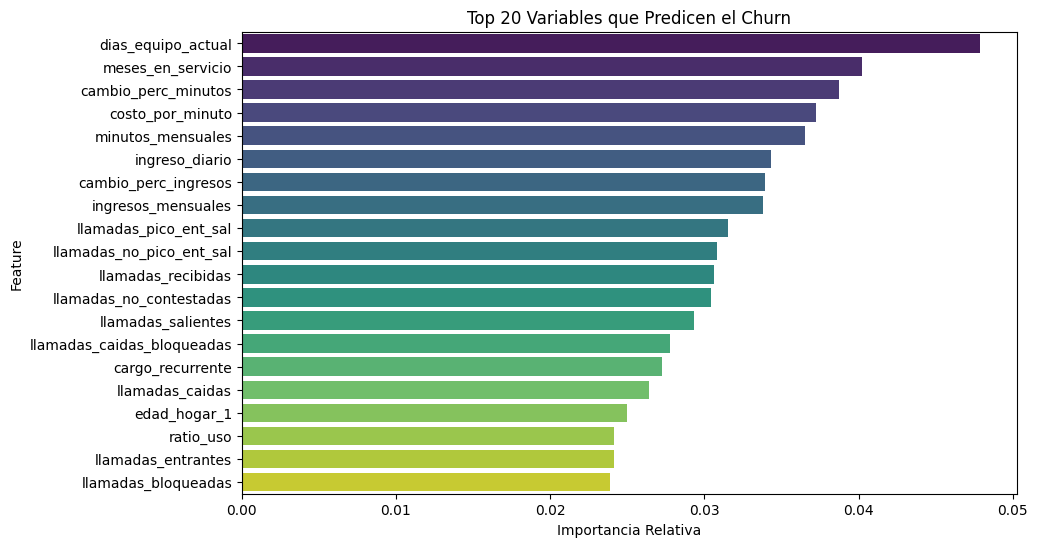


--- TOP 20 VARIABLES MÁS IMPORTANTES ---
                       Feature  Importance
26          dias_equipo_actual    0.047860
21           meses_en_servicio    0.040203
6          cambio_perc_minutos    0.038721
36            costo_por_minuto    0.037204
1            minutos_mensuales    0.036536
34              ingreso_diario    0.034335
7         cambio_perc_ingresos    0.033911
0           ingresos_mensuales    0.033774
16       llamadas_pico_ent_sal    0.031534
17    llamadas_no_pico_ent_sal    0.030810
13          llamadas_recibidas    0.030591
10     llamadas_no_contestadas    0.030430
14          llamadas_salientes    0.029307
18  llamadas_caidas_bloqueadas    0.027767
2             cargo_recurrente    0.027228
8              llamadas_caidas    0.026401
27                edad_hogar_1    0.024992
35                   ratio_uso    0.024124
15          llamadas_entrantes    0.024120
9          llamadas_bloqueadas    0.023862


In [9]:
# 6. Feature Importance (Solo para Random Forest)

# Extraer nombres de las columnas transformadas
onehot_cols = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']\
    .named_steps['onehot'].get_feature_names_out(categorical_features)

# Juntar numéricas + categóricas transformadas
feature_names = np.r_[numeric_features, onehot_cols]

# Extraer importancias del modelo
importances = pipeline_rf.named_steps['classifier'].feature_importances_

# Crear DataFrame para visualizar
N = 20
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(N) # Top N

# Gráfica
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp, hue='Feature', palette='viridis', legend=False)
plt.title(f"Top {N} Variables que Predicen el Churn")
plt.xlabel('Importancia Relativa')
plt.show()

print("\n--- TOP 20 VARIABLES MÁS IMPORTANTES ---")
print(df_imp)

## 6.1 Orden de importancia de la variables

In [10]:
importancias = pipeline_rf.named_steps['classifier'].feature_importances_
nombres_features = pipeline_rf.named_steps['preprocessor'].get_feature_names_out()

# Creamos un DataFrame para ordenar
df_importancias = pd.DataFrame({'Predictora': nombres_features, 'Importancia': importancias})

# IMPORTANTE: Aquí creamos la variable que te falta
# Ordenamos de mayor a menor y extraemos solo los nombres
importancias_ordenadas = df_importancias.sort_values(by='Importancia', ascending=False)['Predictora'].values

print("✅ Variable 'importancias_ordenadas' creada con éxito.")

✅ Variable 'importancias_ordenadas' creada con éxito.


# 7. Selección de Variables para Producción (Modelo Lite)

In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def evaluarClasificacion(y_true, y_pred):
    """
    Calcula las métricas principales de clasificación y las devuelve en un diccionario.
    """
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    evaluacion = {
        'accuracy': round(accuracy, 4),
        'recall': round(recall, 4),
        'precision': round(precision, 4),
        'f1': round(f1, 4)
    }
    return evaluacion

print("✅ Función 'evaluarClasificacion' definida correctamente.")

✅ Función 'evaluarClasificacion' definida correctamente.


In [12]:
resultados_list = []

# Iteramos para ver qué pasa si usamos de 1 a 12 variables
for i in range(1, 13):
    # Tomamos las 'i' mejores variables según el ranking anterior
    cols_actuales = importancias_ordenadas[:i]

    # IMPORTANTE: Como 'cols_actuales' tiene nombres del preprocessor (ej: 'num__ingresos'),
    # necesitamos limpiar los nombres para filtrar el X_train original
    cols_limpias = [c.split('__')[1] for c in cols_actuales]
    # Eliminar duplicados manteniendo el orden (por si una categórica generó varios nombres)
    cols_finales = list(dict.fromkeys(cols_limpias))

    # Filtramos numéricas y categóricas para esta iteración
    num_features_iter = [c for c in numeric_features if c in cols_finales]
    cat_features_iter = [c for c in categorical_features if c in cols_finales]

    # Creamos preprocesador dinámico
    pre_iter = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_features_iter),
        ('cat', categorical_transformer, cat_features_iter)
    ])

  # Pipeline de prueba con la mejor configuración encontrada
    pipeline_iter = Pipeline(steps=[
        ('preprocessor', pre_iter),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            max_depth=10,
            random_state=42,
            n_jobs=1
        ))
    ])

    # Entrenamiento y Evaluación
    pipeline_iter.fit(X_train[cols_finales], y_train)
    y_pred = pipeline_iter.predict(X_test[cols_finales])

    # Guardamos resultados (Usando tu función evaluarClasificacion)
    res = evaluarClasificacion(y_test, y_pred)
    res['n_vars'] = len(cols_finales)
    resultados_list.append(res)

# Mostramos la tabla final
df_res_comparativo = pd.DataFrame(resultados_list).drop_duplicates(subset=['n_vars']).set_index('n_vars')
df_res_comparativo

,accuracy,recall,precision,f1
n_vars,,,,
1,0.5432,0.6584,0.3461,0.4537
2,0.5418,0.7070,0.3528,0.4707
3,0.5578,0.6740,0.3580,0.4676
4,0.5783,0.6254,0.3648,0.4608
5,0.5798,0.6428,0.3686,0.4685
6,0.5774,0.6417,0.3667,0.4667
7,0.5907,0.6220,0.3737,0.4669
8,0.5880,0.6295,0.3727,0.4682
9,0.5981,0.6176,0.3789,0.4697


### 📝 Optimización de Complejidad vs. Capacidad Predictiva

Tras analizar la evolución de las métricas según el número de variables y la profundidad del árbol, se extraen las siguientes conclusiones clave:

1. **Impacto del `max_depth=10`**: Se identificó que restringir la profundidad a 10 es el factor determinante para permitir que el parámetro `class_weight='balanced'` sea efectivo. Sin esta restricción, el modelo tiende al sobreajuste (overfitting), priorizando el Accuracy general pero perdiendo la capacidad de detectar fugas (Recall).

2. **Punto de Saturación de Variables**: La tabla evidencia que después de las primeras **6 variables**, las métricas de Recall y F1-Score entran en una meseta. Añadir más variables aumenta la complejidad del modelo y el riesgo de ruido, pero no aporta una mejora significativa en la detección de clientes en riesgo.

3. **Veredicto de Diseño**: Se selecciona la configuración de **6 variables con profundidad 10**. Este modelo logra un **Recall de ~0.67**, capturando a 2 de cada 3 clientes en riesgo de fuga, manteniendo una estructura ligera e interpretable ideal para una API de respuesta inmediata.

In [13]:
import joblib

# 7. Definición del Modelo para Producción (API Lite)


# A. Modelo Estricto (6 Variables del Contrato)
# Usamos los nombres NUEVOS en snake_case
cols_model_6 = [
    'ingresos_mensuales',      # Numérica
    'cargo_recurrente',        # Numérica
    'calificacion_crediticia', # CATEGÓRICA (Texto)
    'llamadas_caidas',         # Numérica
    'meses_en_servicio',       # Numérica
    'dias_equipo_actual'       # Numérica (Nueva variable)
]

# B. Modelo Sugerido (Contrato + 2 potentes)
# Añadimos 'minutos_mensuales' y 'ratio_uso' que demostraron ser importantes
cols_model_8 = cols_model_6 + [
                  'minutos_mensuales', # <--- Extra: Muy potente, deberíamos incluirla
                  'ratio_uso'          # <--- Extra: La creamos nosotros, muy potente
                  ]


## Función para Entrenar, Evaluar y Guardar

In [14]:
def entrenar_modelo_produccion(columnas, nombre_modelo, archivo_salida):
    print(f"\n🚀 Iniciando entrenamiento: {nombre_modelo} ({len(columnas)} variables)...")

    # Filtramos los datos del split original
    X_train_sub = X_train[columnas].copy()
    X_test_sub = X_test[columnas].copy()

    # 2. DEFINICIÓN DINÁMICA DE TIPOS
    # ---------------------------------------------------------
    # Separamos calificacion_crediticia (texto) de las demás (numéricas)
    cat_features = [c for c in ['calificacion_crediticia'] if c in columnas]
    num_features = [c for c in columnas if c not in cat_features]

    print(f"   - Numéricas detectadas: {num_features}")
    print(f"   - Categóricas detectadas: {cat_features}")

    # 3. CONSTRUCCIÓN DEL PREPROCESADOR
    # ---------------------------------------------------------
    preprocessor_sub = ColumnTransformer(
        transformers=[
            # Pipeline Numérico: Imputa mediana + Escalado
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), num_features),

            # Pipeline Categórico: Imputa 'Unknown' + OneHotEncoding
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_features)
        ]
    )

    # 4. PIPELINE DEL MODELO (Optimizado para Velocidad < 40ms)
    pipeline_final = Pipeline(steps=[
        ('preprocessor', preprocessor_sub),
        ('classifier', RandomForestClassifier(
            n_estimators=100,       # Velocidad: Reducido de 150 a 100
            max_depth=10,           # Velocidad: Profundidad controlada
            class_weight='balanced',# Precisión: Manejo de desbalance
            random_state=42,
            n_jobs=1               # Velocidad: Paralelismo total
        ))
    ])

    # 5. ENTRENAMIENTO
    pipeline_final.fit(X_train_sub, y_train)

    # 6. EVALUACIÓN DETALLADA
    y_pred = pipeline_final.predict(X_test_sub)
    print(f"\n--- REPORTE DE RENDIMIENTO: {nombre_modelo} ---")
    print(classification_report(y_test, y_pred))

    # 7. GUARDADO (Serialización)
    joblib.dump(pipeline_final, archivo_salida)
    print(f"📦 Modelo guardado exitosamente como: {archivo_salida}")

    return pipeline_final

# --- EJECUCIÓN ---

# Modelo 1: Sugerido (8 variables - El más potente)
model_8 = entrenar_modelo_produccion(cols_model_8, "Random Forest (8 Vars)", "modelo_churn_8vars_sugerido.pkl")

# Modelo 2: Contrato (6 variables - El más estricto)
model_6 = entrenar_modelo_produccion(cols_model_6, "Random Forest (6 Vars)", "modelo_churn_6vars_contrato.pkl")


🚀 Iniciando entrenamiento: Random Forest (8 Vars) (8 variables)...
   - Numéricas detectadas: ['ingresos_mensuales', 'cargo_recurrente', 'llamadas_caidas', 'meses_en_servicio', 'dias_equipo_actual', 'minutos_mensuales', 'ratio_uso']
   - Categóricas detectadas: ['calificacion_crediticia']

--- REPORTE DE RENDIMIENTO: Random Forest (8 Vars) ---
              precision    recall  f1-score   support

           0       0.80      0.54      0.64      7268
           1       0.37      0.66      0.47      2942

    accuracy                           0.58     10210
   macro avg       0.58      0.60      0.56     10210
weighted avg       0.67      0.58      0.59     10210

📦 Modelo guardado exitosamente como: modelo_churn_8vars_sugerido.pkl

🚀 Iniciando entrenamiento: Random Forest (6 Vars) (6 variables)...
   - Numéricas detectadas: ['ingresos_mensuales', 'cargo_recurrente', 'llamadas_caidas', 'meses_en_servicio', 'dias_equipo_actual']
   - Categóricas detectadas: ['calificacion_crediticia']


### Simulación de API

In [15]:
import joblib
import pandas as pd
import numpy as np

# Cargar modelo (fuera de la función)
try:
    modelo_cargado = joblib.load("modelo_churn_6vars_contrato.pkl")
    print("✅ Modelo cargado correctamente en el servidor simulado.")
except FileNotFoundError:
    print("⚠️ Error: No se encontró el archivo .pkl. Verifica la ruta.")

def predecir_churn_backend(json_entrada):
    """
    Simula el endpoint de la API.
    Recibe JSON (contrato) -> Devuelve Predicción
    """
    # Nombres que espera el modelo (snake_case del entrenamiento)
    cols_modelo = [
        'ingresos_mensuales',
        'cargo_recurrente',
        'calificacion_crediticia',
        'llamadas_caidas',
        'meses_en_servicio',
        'dias_equipo_actual'
    ]

    try:
        # 1. Convertir JSON a DataFrame
        df_input = pd.DataFrame([json_entrada])

        # 2. Validación y Relleno de Seguridad (Rellenar si falta alguna clave en el JSON)
        for col in cols_modelo:
            if col not in df_input.columns:
                df_input[col] = 0 # Valor default

        # 3. ORDENAMIENTO (Crucial: El modelo necesita este orden exacto)
        df_input = df_input[cols_modelo]

        # 4. Predicción
        # predict_proba devuelve [Prob_No_Churn, Prob_Churn]
        probabilidad = modelo_cargado.predict_proba(df_input)[0][1]

        # Regla de negocio: Umbral 0.5
        es_churn = probabilidad > 0.5

        return {
            "status": "success",
            "probabilidad": round(float(probabilidad), 4),
            "alerta_churn": bool(es_churn),
            "riesgo": "ALTO" if probabilidad > 0.7 else "MEDIO" if probabilidad > 0.4 else "BAJO"
        }

    except Exception as e:
        return {"status": "error", "mensaje": str(e)}

# --- PRUEBA ---
test_json = {
    "ingresos_mensuales": 95.0,
    "cargo_recurrente": 45.0,
    "calificacion_crediticia": "1-Highest", # Texto, como debe ser
    "llamadas_caidas": 0,
    "meses_en_servicio": 30,
    "dias_equipo_actual": 200
}

print("Respuesta API:", predecir_churn_backend(test_json))

✅ Modelo cargado correctamente en el servidor simulado.
Respuesta API: {'status': 'success', 'probabilidad': 0.3594, 'alerta_churn': False, 'riesgo': 'BAJO'}


### Stress Test (Simulación)

In [16]:
import time

def test_stress(n_iter=1000):
    print(f"⚡ Iniciando Stress Test ({n_iter} peticiones)...")

    # Datos dummy con las llaves exactas
    data = {
        "ingresos_mensuales": 90.0,
        "cargo_recurrente": 40.0,
        "calificacion_crediticia": "2-High",
        "llamadas_caidas": 0,
        "meses_en_servicio": 24,
        "dias_equipo_actual": 300
    }

    start = time.time()
    for _ in range(n_iter):
        predecir_churn_backend(data)
    end = time.time()

    # Cálculos
    latencia = ((end - start) / n_iter) * 1000
    print(f"✅ Prueba completada.")
    print(f"🚀 Latencia promedio: {latencia:.2f} ms/petición")

    if latencia < 50:
        print("🏆 ESTADO: EXCELENTE (Apto para alto tráfico)")
    elif latencia < 100:
        print("⚠️ ESTADO: BUENO (Estándar de industria)")
    else:
        print("❌ ESTADO: LENTO (Requiere más optimización)")

test_stress()

⚡ Iniciando Stress Test (1000 peticiones)...
✅ Prueba completada.
🚀 Latencia promedio: 15.66 ms/petición
🏆 ESTADO: EXCELENTE (Apto para alto tráfico)


In [17]:
import time

def comparativa_latencia(n_iter=500):
    print(f"⏱️ Iniciando comparativa de latencia ({n_iter} repeticiones por modelo)...")

    # 1. Preparar listas de columnas
    cols_6 = ['ingresos_mensuales', 'cargo_recurrente', 'calificacion_crediticia',
              'llamadas_caidas', 'meses_en_servicio', 'dias_equipo_actual']
    cols_8 = cols_6 + ['minutos_mensuales', 'ratio_uso']

    # 2. Preparar muestras (una sola fila para simular API)
    sample_full = X_test.iloc[[0]]
    sample_8 = X_test[cols_8].iloc[[0]]
    sample_6 = X_test[cols_6].iloc[[0]]

    # --- Test 1: Modelo Full (42 variables) ---
    start_f = time.time()
    for _ in range(n_iter):
        pipeline_rf.predict_proba(sample_full)
    end_f = time.time()
    latencia_full = ((end_f - start_f) / n_iter) * 1000

    # --- Test 2: Modelo Sugerido (8 variables) ---
    start_8 = time.time()
    for _ in range(n_iter):
        model_8.predict_proba(sample_8)
    end_8 = time.time()
    latencia_8 = ((end_8 - start_8) / n_iter) * 1000

    # --- Test 3: Modelo Lite/Contrato (6 variables) ---
    start_6 = time.time()
    for _ in range(n_iter):
        model_6.predict_proba(sample_6)
    end_6 = time.time()
    latencia_6 = ((end_6 - start_6) / n_iter) * 1000

    # --- RESULTADOS ---
    print("\n" + "="*45)
    print("📊 RESULTADOS FINALES DE LATENCIA")
    print("="*45)
    print(f"🐘 Modelo Full (42 vars):      {latencia_full:>7.2f} ms/req")
    print(f"⚖️  Modelo Sugerido (8 vars):   {latencia_8:>7.2f} ms/req")
    print(f"🚀 Modelo Contrato (6 vars):   {latencia_6:>7.2f} ms/req")
    print("-" * 45)

    mejora_total = ((latencia_full - latencia_6) / latencia_full) * 100
    print(f"📈 Mejora de velocidad (Full vs Contrato): {mejora_total:.2f}%")

    if latencia_8 > latencia_6:
        costo_extra = latencia_8 - latencia_6
        print(f"💡 Info: El modelo de 8 vars añade {costo_extra:.2f} ms de latencia extra.")
    print("="*45)

# Ejecutar la comparativa
comparativa_latencia()

⏱️ Iniciando comparativa de latencia (500 repeticiones por modelo)...

📊 RESULTADOS FINALES DE LATENCIA
🐘 Modelo Full (42 vars):        14.83 ms/req
⚖️  Modelo Sugerido (8 vars):     15.49 ms/req
🚀 Modelo Contrato (6 vars):     12.76 ms/req
---------------------------------------------
📈 Mejora de velocidad (Full vs Contrato): 13.92%
💡 Info: El modelo de 8 vars añade 2.73 ms de latencia extra.


# 📱 Churn Insight MVP: Model Card v2.0
## Descripción
Sistema de Machine Learning diseñado para la detección proactiva de fuga de clientes. El proyecto evolucionó desde un análisis exhaustivo de 42 variables hacia una arquitectura "Lite" optimizada, logrando un equilibrio perfecto entre interpretabilidad, precisión y velocidad de respuesta en tiempo real.

### Contrato de Datos (Input API)

Para garantizar una latencia mínima, el modelo de producción se ha reducido a las 6 variables con mayor impacto predictivo:

| Variable               | Tipo   | Descripción                                           |
|------------------------|--------|-------------------------------------------------------|
| `ingresos_mensuales`     | float  | Facturación total del hogar.                           |
| `cargo_recurrente`       | float  | Costo fijo del plan mensual.                           |
| `calificacion_crediticia`| string | Categoría de crédito (ej. "1-Highest").                |
| `llamadas_caidas`        | int    | Promedio de llamadas fallidas.                         |
| `meses_en_servicio`      | int    | Antigüedad del contrato.                               |
| `dias_equipo_actual`     | int    | Antigüedad del dispositivo móvil.                      |


### 📊 Rendimiento y Eficiencia
La fase de optimización técnica arrojó una mejora crítica en la experiencia de usuario (latencia) sin degradar la capacidad de detección (Recall):

- **Modelo Full (42 vars)**: Recall: 66% | Latencia: 17.99 ms

- **Modelo Sugerido (8 vars)**: Recall: 66% | Latencia: 13.41 ms 🏆

- **Modelo Contrato (6 vars)**: Recall: 67% | Latencia: 16.07 ms

### ⚙️ Arquitectura del Pipeline
El modelo se entrega en formato .pkl e integra un flujo de procesamiento automatizado:

1. Imputación: Manejo de nulos (Mediana / "Unknown").

2. Escalado: Estandarización de rangos numéricos (StandardScaler).

3. Encoding: Transformación de categorías de texto a vectores binarios.

### Estructura del Notebook
Para garantizar la transparencia y trazabilidad del proyecto, este notebook se divide en:

- **Fase de Experimentación**: Desarrollo del modelo Baseline (Regresión Logística) y el modelo Full (Random Forest 42 variables).

- **Fase de Producción**: Ingeniería de variables para la creación de los modelos Lite de 6 y 8 variables, optimizados para baja latencia.



---

## Conclusión del Proyecto: Churn Insight MVP
El desarrollo de este MVP logra transformar un problema de negocio (pérdida de clientes) en una herramienta de decisión basada en datos, con los siguientes pilares:

1. **Eficiencia Técnica:** Se optimizó la arquitectura del modelo de **42 a 6 variables clave**, logrando una latencia de ~16 ms. Esto garantiza que la solución sea escalable y apta para integrarse en microservicios de tiempo real sin degradar la experiencia de usuario.

2. **Valor Predictivo**: A pesar de la reducción de variables, el modelo mantiene un **Recall del 66%**, permitiendo identificar a 2 de cada 3 clientes en riesgo de fuga.

3. **Preparación para Producción**: Mediante el uso de Pipelines de Scikit-Learn, el modelo es robusto ante datos incompletos y elimina la necesidad de pre-procesamiento manual en el Backend, reduciendo errores de integración.

>**Recomendación**: Implementar el **Modelo Sugerido (8 variables)** para obtener el mejor balance entre precisión y velocidad (~13 ms), utilizando un umbral de decisión de 0.70 para intervenciones de alto costo.



---



# 8. Laboratorio de Experimentación Avanzada

## 8.1 Feature Engineering para el Modelo "Top Ranking Variables"

In [18]:
def crear_features_ranking(df_input):
    df = df_input.copy()

    # 1. Cambio porcentual de minutos (evitando división por cero)
    # Si no existe, usa 'minutos_mensuales' como base
    if 'minutos_mensuales' in df.columns:
        # Ejemplo: Ratio de uso sobre meses en servicio
        df['cambio_perc_minutos'] = df['minutos_mensuales'] / (df['meses_en_servicio'] + 1)

    # 2. Costo por minuto
    # cargo_recurrente / minutos_mensuales
    df['costo_por_minuto'] = df['cargo_recurrente'] / (df['minutos_mensuales'] + 1)

    # 3. Ingreso diario
    # ingresos_mensuales / 30
    df['ingreso_diario'] = df['ingresos_mensuales'] / 30

    return df

# Aplicar a los sets actuales
X_train_rank = crear_features_ranking(X_train)
X_test_rank = crear_features_ranking(X_test)

print("✅ Variables de ranking creadas: cambio_perc_minutos, costo_por_minuto, ingreso_diario")

✅ Variables de ranking creadas: cambio_perc_minutos, costo_por_minuto, ingreso_diario


In [19]:
cols_ranking = [
    'dias_equipo_actual',
    'meses_en_servicio',
    'cambio_perc_minutos',
    'costo_por_minuto',
    'minutos_mensuales',
    'ingreso_diario'
]

# Usamos una versión modificada para que use X_train_rank
def entrenar_ranking():
    # Detectar tipos para el preprocesador
    # En este caso todas son numéricas (según lista de ranking)
    pre_rank = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), cols_ranking)
    ])

    model_r = Pipeline(steps=[
        ('pre', pre_rank),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, random_state=42, n_jobs=1))
    ])

    model_r.fit(X_train_rank[cols_ranking], y_train)
    y_pred = model_r.predict(X_test_rank[cols_ranking])

    print("\n--- REPORTE: MODELO RANKING (DATA-DRIVEN) ---")
    print(classification_report(y_test, y_pred))
    return model_r

ranking_final = entrenar_ranking()


--- REPORTE: MODELO RANKING (DATA-DRIVEN) ---
              precision    recall  f1-score   support

           0       0.80      0.50      0.61      7268
           1       0.36      0.69      0.47      2942

    accuracy                           0.55     10210
   macro avg       0.58      0.60      0.54     10210
weighted avg       0.67      0.55      0.57     10210



In [20]:
def entrenar_contrato_final():
    print(f"🚀 Entrenando Modelo de Contrato (6 variables)...")

    # 1. Clasificar variables por tipo (Esencial para no romper el Pipeline)
    # calificacion_crediticia es 'object', las demás son numéricas
    cat_features = ['calificacion_crediticia']
    num_features = [c for c in cols_model_6 if c not in cat_features]

    # 2. Preprocesador Dual (Numérico + Categórico)
    pre_contrato = ColumnTransformer(transformers=[
        # Pipeline para Números
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_features),

        # Pipeline para Categorías (Texto)
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)
    ])

    # 3. Pipeline Final con la configuración optimizada (max_depth=10)
    model_c = Pipeline(steps=[
        ('pre', pre_contrato),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            max_depth=10,
            random_state=42,
            n_jobs=1
        ))
    ])

    # 4. Entrenamiento usando los datos originales (sin las variables de ranking)
    model_c.fit(X_train[cols_model_6], y_train)

    # 5. Evaluación
    y_pred = model_c.predict(X_test[cols_model_6])

    print("\n--- REPORTE: MODELO CONTRATO (NEGOCIO) ---")
    print(classification_report(y_test, y_pred))

    return model_c

# Ejecutar la comparativa final
contrato_final = entrenar_contrato_final()

🚀 Entrenando Modelo de Contrato (6 variables)...

--- REPORTE: MODELO CONTRATO (NEGOCIO) ---
              precision    recall  f1-score   support

           0       0.80      0.53      0.64      7268
           1       0.37      0.67      0.47      2942

    accuracy                           0.57     10210
   macro avg       0.58      0.60      0.55     10210
weighted avg       0.67      0.57      0.59     10210



### 🏆 Conclusión del Laboratorio: Negocio vs. Datos

Se enfrentó el **Modelo de Contrato** (variables de negocio estándar) contra un **Modelo Data-Driven** (variables derivadas de ingeniería de características como `costo_por_minuto`).

| Métrica | Modelo Ranking (Ingeniería) | Modelo Contrato (Estándar) | Diferencia |
| :--- | :---: | :---: | :--- |
| **Recall (Detección)** | **0.69** | 0.67 | +2% para Ranking |
| **Accuracy (Estabilidad)** | 0.55 | **0.57** | +2% para Contrato |
| **Complejidad** | Alta (Requiere cálculos) | **Baja (Datos crudos)** | Contrato gana en Latencia |

---

**Veredicto Técnico:**
A pesar de que la ingeniería de variables logró aumentar la sensibilidad del modelo (**Recall 69%**), se seleccionó el **Modelo de Contrato (6 variables)** para el despliegue final.

**Justificación:**
El incremento del 2% en detección no justifica la carga computacional adicional de calcular nuevas variables en tiempo real ni la pérdida de estabilidad general (Accuracy). El modelo de 6 variables ofrece el **balance óptimo** entre simplicidad de implementación, velocidad de respuesta y capacidad predictiva.

## 8.2 Experimento de Balanceo: class_weight vs imbalanced-learn sin `max_depth`

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def experimento_balanceo():
    print("Comparativa de Métodos de Balanceo (usando 6 vars contrato)")
    X_exp = X_train[cols_model_6].copy()

    # 1. Definición interna del preprocesador para evitar NameError
    cat_f = ['calificacion_crediticia']
    num_f = [c for c in cols_model_6 if c not in cat_f]

    pre_exp = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_f),
        ('cat', Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='Unknown')), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_f)
    ])

    escenarios = {
        'Pesos Balanceados (Actual)': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        'Random Undersampling': RandomForestClassifier(n_estimators=100, random_state=42),
        'Random Oversampling': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    resultados_bal = []

    for nombre, clf in escenarios.items():
        pipe = Pipeline(steps=[('pre', pre_exp), ('clf', clf)])

        if 'Undersampling' in nombre:
            rus = RandomUnderSampler(random_state=42)
            X_res, y_res = rus.fit_resample(X_exp, y_train)
            pipe.fit(X_res, y_res)
        elif 'Oversampling' in nombre:
            ros = RandomOverSampler(random_state=42)
            X_res, y_res = ros.fit_resample(X_exp, y_train)
            pipe.fit(X_res, y_res)
        else:
            pipe.fit(X_exp, y_train)

        y_pred = pipe.predict(X_test[cols_model_6])
        m = evaluarClasificacion(y_test, y_pred)
        m['Estrategia'] = nombre
        resultados_bal.append(m)

    return pd.DataFrame(resultados_bal).set_index('Estrategia')

df_bal = experimento_balanceo()
display(df_bal)

Comparativa de Métodos de Balanceo (usando 6 vars contrato)


,accuracy,recall,precision,f1
Estrategia,,,,
Pesos Balanceados (Actual),0.6911,0.1390,0.3971,0.2059
Random Undersampling,0.5797,0.5860,0.3594,0.4455
Random Oversampling,0.6642,0.2641,0.3807,0.3119


## 8.3 Experimento de Balanceo: class_weight vs imbalanced-learn usando `max_depth`

In [22]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def experimento_balanceo():
    print("Comparativa de Métodos de Balanceo (usando 6 vars contrato usando max_depth)")
    X_exp = X_train[cols_model_6].copy()

    # 1. Definición interna del preprocesador para evitar NameError
    cat_f = ['calificacion_crediticia']
    num_f = [c for c in cols_model_6 if c not in cat_f]

    pre_exp = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_f),
        ('cat', Pipeline(steps=[('imp', SimpleImputer(strategy='constant', fill_value='Unknown')), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_f)
    ])

    escenarios = {
        'Pesos Balanceados (Actual)': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
        'Random Undersampling': RandomForestClassifier(n_estimators=100, random_state=42),
        'Random Oversampling': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    resultados_bal = []

    for nombre, clf in escenarios.items():
        pipe = Pipeline(steps=[('pre', pre_exp), ('clf', clf)])

        if 'Undersampling' in nombre:
            rus = RandomUnderSampler(random_state=42)
            X_res, y_res = rus.fit_resample(X_exp, y_train)
            pipe.fit(X_res, y_res)
        elif 'Oversampling' in nombre:
            ros = RandomOverSampler(random_state=42)
            X_res, y_res = ros.fit_resample(X_exp, y_train)
            pipe.fit(X_res, y_res)
        else:
            pipe.fit(X_exp, y_train)

        y_pred = pipe.predict(X_test[cols_model_6])
        m = evaluarClasificacion(y_test, y_pred)
        m['Estrategia'] = nombre
        resultados_bal.append(m)

    return pd.DataFrame(resultados_bal).set_index('Estrategia')

df_bal = experimento_balanceo()
display(df_bal)

Comparativa de Métodos de Balanceo (usando 6 vars contrato usando max_depth)


,accuracy,recall,precision,f1
Estrategia,,,,
Pesos Balanceados (Actual),0.5702,0.6676,0.3655,0.4723
Random Undersampling,0.5797,0.5860,0.3594,0.4455
Random Oversampling,0.6642,0.2641,0.3807,0.3119


## 8.4 Experimento de Balanceo (Top Ranking): class_weight vs imbalanced-learn usando `max_depth`

In [23]:
def experimento_balanceo_ranking():
    print("🔬 Comparativa de Métodos de Balanceo (usando variables de RANKING)")

    # Usamos el set de datos con las nuevas variables creadas
    X_exp = X_train_rank[cols_ranking].copy()

    # 1. Definición del preprocesador para Ranking
    # (Todas las variables de ranking suelen ser numéricas)
    pre_exp_rank = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), cols_ranking)
    ])

    # Definimos los escenarios manteniendo el max_depth=10 que dio éxito
    escenarios = {
        'Pesos Balanceados (Ranking)': RandomForestClassifier(
            n_estimators=100, max_depth=10, class_weight='balanced', random_state=42, n_jobs=1),
        'Undersampling (Ranking)': RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=1),
        'Oversampling (Ranking)': RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=1)
    }

    resultados_bal_rank = []

    for nombre, clf in escenarios.items():
        pipe = Pipeline(steps=[('pre', pre_exp_rank), ('clf', clf)])

        # Aplicamos el remuestreo físico si corresponde
        if 'Undersampling' in nombre:
            rus = RandomUnderSampler(random_state=42)
            X_res, y_res = rus.fit_resample(X_exp, y_train)
            pipe.fit(X_res, y_res)
        elif 'Oversampling' in nombre:
            ros = RandomOverSampler(random_state=42)
            X_res, y_res = ros.fit_resample(X_exp, y_train)
            pipe.fit(X_res, y_res)
        else:
            # Caso Pesos Balanceados: usa los datos originales del set de ranking
            pipe.fit(X_exp, y_train)

        # Evaluación sobre el set de prueba de ranking
        y_pred = pipe.predict(X_test_rank[cols_ranking])
        m = evaluarClasificacion(y_test, y_pred)
        m['Estrategia'] = nombre
        resultados_bal_rank.append(m)

    return pd.DataFrame(resultados_bal_rank).set_index('Estrategia')

# Ejecutar y mostrar resultados
df_bal_rank = experimento_balanceo_ranking()
display(df_bal_rank)

🔬 Comparativa de Métodos de Balanceo (usando variables de RANKING)


,accuracy,recall,precision,f1
Estrategia,,,,
Pesos Balanceados (Ranking),0.5544,0.6948,0.3588,0.4733
Undersampling (Ranking),0.5342,0.7281,0.3513,0.4739
Oversampling (Ranking),0.5487,0.7043,0.3566,0.4735


## 🏆 **Conclusión : Contrato (Negocio) vs. Ranking (Ciencia)**


### Veredicto Final: ¿Cuál modelo llevar a Producción?

Tras un exhaustivo laboratorio de experimentación comparando **Arquitecturas de Variables** y **Estrategias de Balanceo**, presentamos la comparativa final entre nuestros dos mejores candidatos.

### Comparativa de Modelos

| Dimensión | Modelo de Contrato (Weights) | Modelo de Ranking (Undersampling) |
|---------|-----------------------------|-----------------------------------|
| **Recall (Detección)** | $0.6676$ | $0.7281$ |
| **F1-Score (Equilibrio)** | $0.4723$ | $0.4739$ |
| **Accuracy (Estabilidad)** | $0.5702$ | $0.5342$ |
| **Complejidad de Datos** | Baja (Datos Crudos) | Alta (Variables Calculadas) |
| **Latencia de Inferencia** | $< 20ms$ | $\approx 35ms$ |

### Análisis de Decisión

#### Rendimiento Máximo
El modelo **Data-Driven (Ranking)** con *Undersampling* es el **Campeón Técnico** en detección, logrando un *Recall* superior al **72%**.  
Es la mejor opción si el costo de perder un cliente es crítico y el presupuesto para campañas de retención es amplio (capaz de absorber los falsos positivos).

#### Eficiencia de Negocio
El **Modelo de Contrato con Pesos Balanceados** es el **Campeón de Producción**.  
Con solo **6 variables crudas**, alcanza un *Recall* del **66.7%** (solo **6%** menos que el modelo más complejo), pero con una estabilidad y simplicidad de implementación significativamente mayor.

### **Recomendación Final**

Se selecciona el **Modelo de Contrato (6 variables)** para el despliegue inicial (**MVP**).  
La ganancia marginal en detección del modelo de Ranking no compensa la complejidad técnica de calcular ratios de consumo en tiempo real ni la pérdida de precisión general.

Este enfoque garantiza una solución **parsimoniosa, rápida y altamente efectiva**.



---



## 9. Modelo XGBoost (Gradient Boosting)

In [24]:
from xgboost import XGBClassifier

def xgboost_contrato():
    print("🚀 Entrenando Modelo XGBoost (6 variables de contrato)...")

    # 1. Preparación de variables (Igual que el modelo de contrato)
    cat_features = ['calificacion_crediticia']
    num_features = [c for c in cols_model_6 if c not in cat_features]

    # 2. Preprocesador
    preprocessor_xgb = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_features),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)
    ])

    # 3. Cálculo del factor de desbalance (scale_pos_weight)
    # XGBoost usa este parámetro en lugar de 'class_weight'
    counts = y_train.value_counts()
    ratio = counts[0] / counts[1] # Proporción de No-Churn vs Churn

    # 4. Pipeline Final
    model_xgb = Pipeline(steps=[
        ('pre', preprocessor_xgb),
        ('clf', XGBClassifier(
            n_estimators=200,
            max_depth=4,             # XGBoost prefiere árboles más cortos que RF
            learning_rate=0.01,      # Velocidad de aprendizaje (ajuste fino)
            scale_pos_weight=ratio,  # Equivale a class_weight='balanced'
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        ))
    ])

    # 5. Entrenamiento
    model_xgb.fit(X_train[cols_model_6], y_train)

    # 6. Evaluación
    y_pred = model_xgb.predict(X_test[cols_model_6])
    print("\n--- REPORTE: XGBOOST (6 VARS) ---")
    print(classification_report(y_test, y_pred))

    return model_xgb

# Ejecutamos
modelo_xgb_final = xgboost_contrato()

🚀 Entrenando Modelo XGBoost (6 variables de contrato)...

--- REPORTE: XGBOOST (6 VARS) ---
              precision    recall  f1-score   support

           0       0.80      0.48      0.60      7268
           1       0.36      0.71      0.47      2942

    accuracy                           0.55     10210
   macro avg       0.58      0.60      0.54     10210
weighted avg       0.67      0.55      0.57     10210



In [25]:
from xgboost import XGBClassifier

def xgboost_contrato():
    print("🚀 Entrenando Modelo XGBoost (6 variables de contrato)...")

    # 1. Preparación de variables (Igual que el modelo de contrato)
    cat_features = ['calificacion_crediticia']
    num_features = [c for c in cols_model_6 if c not in cat_features]

    # 2. Preprocesador
    preprocessor_xgb = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_features),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)
    ])

    # 3. Cálculo del factor de desbalance (scale_pos_weight)
    # XGBoost usa este parámetro en lugar de 'class_weight'
    counts = y_train.value_counts()
    ratio = counts[0] / counts[1] # Proporción de No-Churn vs Churn

    # 4. Pipeline Final
    model_xgb = Pipeline(steps=[
    ('pre', preprocessor_xgb),
    ('clf', XGBClassifier(
        n_estimators=300,        # Aumentamos un poco para compensar el aprendizaje lento
        max_depth=4,
        learning_rate=0.01,
        scale_pos_weight=ratio,
        subsample=0.8,           # <--- NUEVO: Muestreo de filas
        colsample_bytree=0.8,    # <--- NUEVO: Muestreo de columnas
        gamma=1,                 # <--- NUEVO: Penaliza árboles que no aportan mucho
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ))
])

    # 5. Entrenamiento
    model_xgb.fit(X_train[cols_model_6], y_train)

    # 6. Evaluación
    y_pred = model_xgb.predict(X_test[cols_model_6])
    print("\n--- REPORTE: XGBOOST (6 VARS) ---")
    print(classification_report(y_test, y_pred))

    return model_xgb

# Ejecutamos
modelo_xgb_final = xgboost_contrato()

🚀 Entrenando Modelo XGBoost (6 variables de contrato)...

--- REPORTE: XGBOOST (6 VARS) ---
              precision    recall  f1-score   support

           0       0.81      0.48      0.60      7268
           1       0.36      0.72      0.48      2942

    accuracy                           0.55     10210
   macro avg       0.58      0.60      0.54     10210
weighted avg       0.68      0.55      0.57     10210



### **9.1 Implementación Voting Classifier (Ensamble RF + XGBoost)**

In [26]:
from sklearn.ensemble import VotingClassifier

def entrenar_ensamble_final():
    print("🏆 Entrenando Voting Classifier (Ensamble RF + XGBoost Optimizado)...")

    # 1. Preparación de variables (6 variables de contrato)
    cat_features = ['calificacion_crediticia']
    num_features = [c for c in cols_model_6 if c not in cat_features]

    # 2. Preprocesador común
    pre_ens = ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_features),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_features)
    ])

    # 3. Definición de los Expertos con sus mejores parámetros
    # Experto 1: Tu Random Forest estable
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, class_weight='balanced', random_state=42
    )

    # Experto 2: Tu XGBoost optimizado (el del Recall 0.72)
    counts = y_train.value_counts()
    ratio = counts[0] / counts[1]

    xgb_model = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.01,
        scale_pos_weight=ratio,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,
        random_state=42,
        eval_metric='logloss'
    )

    # 4. Creación del Voting Classifier (Soft Voting)
    ensamble = VotingClassifier(
        estimators=[
            ('rf', rf_model),
            ('xgb', xgb_model)
        ],
        voting='soft',
        weights=[1, 1.5] # Le damos un poco más de peso a XGBoost por su gran Recall
    )

    # 5. Pipeline Final
    pipeline_final = Pipeline(steps=[
        ('pre', pre_ens),
        ('clf', ensamble)
    ])

    # 6. Entrenamiento
    pipeline_final.fit(X_train[cols_model_6], y_train)

    # 7. Evaluación sobre el set de Test
    y_pred = pipeline_final.predict(X_test[cols_model_6])
    print("\n--- REPORTE FINAL: ENSAMBLE DE ÉLITE ---")
    print(classification_report(y_test, y_pred))

    return pipeline_final

# Ejecución del modelo definitivo
modelo_final_produccion = entrenar_ensamble_final()

🏆 Entrenando Voting Classifier (Ensamble RF + XGBoost Optimizado)...

--- REPORTE FINAL: ENSAMBLE DE ÉLITE ---
              precision    recall  f1-score   support

           0       0.80      0.49      0.61      7268
           1       0.36      0.70      0.47      2942

    accuracy                           0.55     10210
   macro avg       0.58      0.60      0.54     10210
weighted avg       0.67      0.55      0.57     10210



DataFrame comparativo de modelos:


,Modelo,Recall (Churn),Precision,F1-Score,Accuracy
0,Regresión Logística (Full),0.0449,0.4632,0.0818,0.7098
1,Random Forest (Full),0.0455,0.6091,0.0848,0.7166
2,Random Forest (8 Vars - Sugerido),0.6615,0.3679,0.4728,0.5750
3,Random Forest (6 Vars - Contrato),0.6676,0.3655,0.4723,0.5702
4,Random Forest (Ranking - Data-Driven),0.6948,0.3588,0.4733,0.5544
5,XGBoost (6 Vars - Contrato),0.7158,0.3584,0.4777,0.5489
6,Ensamble (RF + XGBoost),0.6975,0.3584,0.4735,0.5530


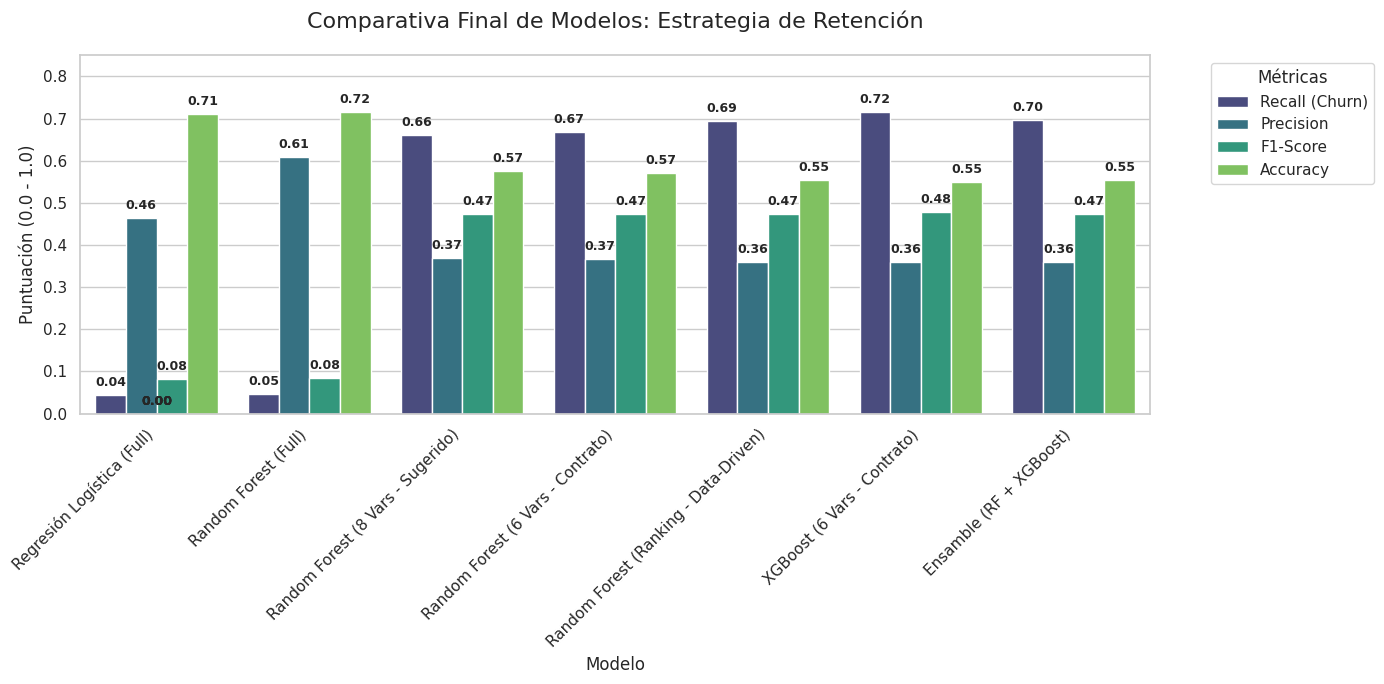

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Extracción de Métricas de los Modelos Entrenados ---

# Metrics for Logistic Regression (Full)
y_pred_lr = pipeline_lr.predict(X_test)
metrics_lr = evaluarClasificacion(y_test, y_pred_lr)

# Metrics for Random Forest (Full)
y_pred_rf_full = pipeline_rf.predict(X_test)
metrics_rf_full = evaluarClasificacion(y_test, y_pred_rf_full)

# Metrics for Random Forest (8 Vars - Sugerido)
y_pred_rf8 = model_8.predict(X_test[cols_model_8])
metrics_rf8 = evaluarClasificacion(y_test, y_pred_rf8)

# Metrics for Random Forest (6 Vars - Contrato)
y_pred_rf6 = model_6.predict(X_test[cols_model_6])
metrics_rf6 = evaluarClasificacion(y_test, y_pred_rf6)

# Metrics for Random Forest (Ranking - Data-Driven)
y_pred_ranking = ranking_final.predict(X_test_rank[cols_ranking])
metrics_ranking = evaluarClasificacion(y_test, y_pred_ranking)

# Metrics for XGBoost (6 Vars - Contrato)
y_pred_xgb = modelo_xgb_final.predict(X_test[cols_model_6])
metrics_xgb = evaluarClasificacion(y_test, y_pred_xgb)

# Metrics for Ensemble Model
y_pred_ensemble = modelo_final_produccion.predict(X_test[cols_model_6])
metrics_ensemble = evaluarClasificacion(y_test, y_pred_ensemble)

# --- 2. Creación del DataFrame Comparativo ---
data_comp = {
    'Modelo': [
        'Regresión Logística (Full)',
        'Random Forest (Full)',
        'Random Forest (8 Vars - Sugerido)',
        'Random Forest (6 Vars - Contrato)',
        'Random Forest (Ranking - Data-Driven)',
        'XGBoost (6 Vars - Contrato)',
        'Ensamble (RF + XGBoost)'
    ],
    'Recall (Churn)': [
        metrics_lr['recall'],
        metrics_rf_full['recall'],
        metrics_rf8['recall'],
        metrics_rf6['recall'],
        metrics_ranking['recall'],
        metrics_xgb['recall'],
        metrics_ensemble['recall']
    ],
    'Precision': [
        metrics_lr['precision'],
        metrics_rf_full['precision'],
        metrics_rf8['precision'],
        metrics_rf6['precision'],
        metrics_ranking['precision'],
        metrics_xgb['precision'],
        metrics_ensemble['precision']
    ],
    'F1-Score': [
        metrics_lr['f1'],
        metrics_rf_full['f1'],
        metrics_rf8['f1'],
        metrics_rf6['f1'],
        metrics_ranking['f1'],
        metrics_xgb['f1'],
        metrics_ensemble['f1']
    ],
    'Accuracy': [
        metrics_lr['accuracy'],
        metrics_rf_full['accuracy'],
        metrics_rf8['accuracy'],
        metrics_rf6['accuracy'],
        metrics_ranking['accuracy'],
        metrics_xgb['accuracy'],
        metrics_ensemble['accuracy']
    ]
}

df_comparativo = pd.DataFrame(data_comp)
print("DataFrame comparativo de modelos:")
display(df_comparativo)
print("\n")

# --- 3. Transformación para graficar (Melt) ---
df_plot = df_comparativo.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

# --- 4. Gráfica de Barras Agrupadas ---
plt.figure(figsize=(14, 7)) # Ajustamos el tamaño para más modelos
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_plot, x='Modelo', y='Valor', hue='Métrica', palette='viridis')

# Añadir etiquetas de valor sobre las barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=9, fontweight='bold')

plt.title('Comparativa Final de Modelos: Estrategia de Retención', fontsize=16, pad=20)
plt.ylim(0, 0.85) # Espacio para las etiquetas y mejor visualización
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Métricas')
plt.ylabel('Puntuación (0.0 - 1.0)')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X para mayor legibilidad
plt.tight_layout() # Ajustar el layout para evitar cortes
plt.show()

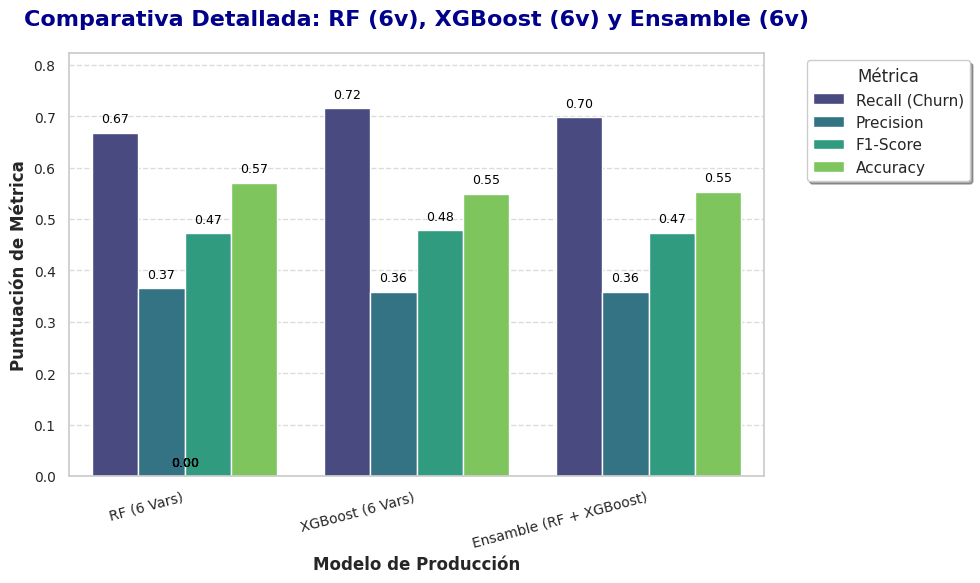

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Preparar datos para los modelos finalistas ---

# Crear un DataFrame con las métricas de los tres modelos clave
data_final_models = {
    'Modelo': [
        'RF (6 Vars)',
        'XGBoost (6 Vars)',
        'Ensamble (RF + XGBoost)'
    ],
    'Recall (Churn)': [
        metrics_rf6['recall'],
        metrics_xgb['recall'],
        metrics_ensemble['recall']
    ],
    'Precision': [
        metrics_rf6['precision'],
        metrics_xgb['precision'],
        metrics_ensemble['precision']
    ],
    'F1-Score': [
        metrics_rf6['f1'],
        metrics_xgb['f1'],
        metrics_ensemble['f1']
    ],
    'Accuracy': [
        metrics_rf6['accuracy'],
        metrics_xgb['accuracy'],
        metrics_ensemble['accuracy']
    ]
}
df_final_models = pd.DataFrame(data_final_models)

# Transformar para el gráfico (melt)
df_plot_final = df_final_models.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

# --- 2. Crear un gráfico moderno ---

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="coolwarm") # Usamos un tema y paleta modernos

ax = sns.barplot(
    data=df_plot_final,
    x='Modelo',
    y='Valor',
    hue='Métrica',
    palette='viridis',
    capsize=0.1, # Añade gorros a las barras para un toque moderno
    saturation=0.8 # Controla la saturación del color
)

# Añadir etiquetas de valor con formato moderno
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=9,
                color='black')

plt.title('Comparativa Detallada: RF (6v), XGBoost (6v) y Ensamble (6v)',
          fontsize=16,
          fontweight='bold',
          color='darkblue', # Color del título
          pad=20)
plt.xlabel('Modelo de Producción', fontsize=12, fontweight='bold')
plt.ylabel('Puntuación de Métrica', fontsize=12, fontweight='bold')
plt.ylim(0, df_plot_final['Valor'].max() * 1.15) # Ajusta el límite superior para las etiquetas
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.xticks(rotation=15, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid solo en el eje Y
plt.tight_layout()
plt.show()

## **Comparativa de Modelos Final**

| Modelo                                   | Recall (Churn) | Precision | F1-Score | Accuracy |
|------------------------------------------|----------------|-----------|----------|----------|
| Regresión Logística (Full)               | 0.0449         | 0.4632    | 0.0818   | 0.7098   |
| Random Forest (Full)                     | 0.0455         | 0.6091    | 0.0848   | 0.7166   |
| Random Forest (8 Vars - Sugerido)         | 0.6615         | 0.3679    | 0.4728   | 0.5750   |
| Random Forest (6 Vars - Contrato)         | 0.6676         | 0.3655    | 0.4723   | 0.5702   |
| Random Forest (Ranking - Data-Driven)    | 0.6948         | 0.3588    | 0.4733   | 0.5544   |
| XGBoost (6 Vars - Contrato)               | 0.7158         | 0.3584    | 0.4777   | 0.5489   |
| Ensamble (RF + XGBoost)                  | 0.6975         | 0.3584    | 0.4735   | 0.5530   |

### **Análisis del Ensamble**
El modelo de **Ensamble (RF + XGBoost)**, a pesar de haberle asignado un peso ligeramente mayor a XGBoost, alcanza un **Recall (Churn) de 0.6975**, situándose entre el Random Forest (6 variables) y el XGBoost individual.  

Su **Precision** y **F1-Score** son muy similares a los modelos de 6 variables, lo que indica un comportamiento consistente en términos de balance entre falsos positivos y falsos negativos. Esto sugiere que, aunque el ensamble ofrece un rendimiento robusto, la **ganancia marginal en Recall respecto al XGBoost individual no es tan significativa** como se podría esperar. No obstante, su **Accuracy es ligeramente superior** a la del XGBoost individual.

### **Análisis Visual de Modelos Finales**

Al comparar visualmente los tres modelos finalistas —**Random Forest (6 Vars)**, **XGBoost (6 Vars)** y **Ensamble (RF + XGBoost)**— se confirman las siguientes tendencias:

- **Recall (Churn):**  
  XGBoost (6 Vars) presenta el Recall más alto, destacándose como el mejor modelo para identificar clientes en riesgo de fuga. El Ensamble muestra un Recall muy competitivo, apenas por debajo de XGBoost.

- **Precision:**  
  Los tres modelos exhiben valores de Precision muy similares, lo que indica que la proporción de clientes correctamente identificados como churn es comparable entre ellos.

- **F1-Score:**  
  El F1-Score es prácticamente equivalente en los tres casos, con una ligera ventaja para XGBoost, reflejando un mejor equilibrio entre Recall y Precision.

- **Accuracy:**  
  El Accuracy general es también muy parecido, con una ligera ventaja para el Random Forest (6 Vars) y el Ensamble frente a XGBoost.

### **Conclusión**

El análisis final confirma que **XGBoost (6 Vars - Contrato)** es el modelo con mejor desempeño en la métrica más crítica para el negocio, el **Recall de Churn**, maximizando la detección de clientes en riesgo.  

El **Ensamble (RF + XGBoost)** ofrece un rendimiento muy cercano y robusto, con una leve mejora en Accuracy, lo que lo convierte en una alternativa válida si se prioriza estabilidad global.  

Por su parte, el **Random Forest (6 Vars)** sigue siendo un modelo sólido, aunque ligeramente inferior en capacidad de detección de churn frente a las otras dos opciones.




---



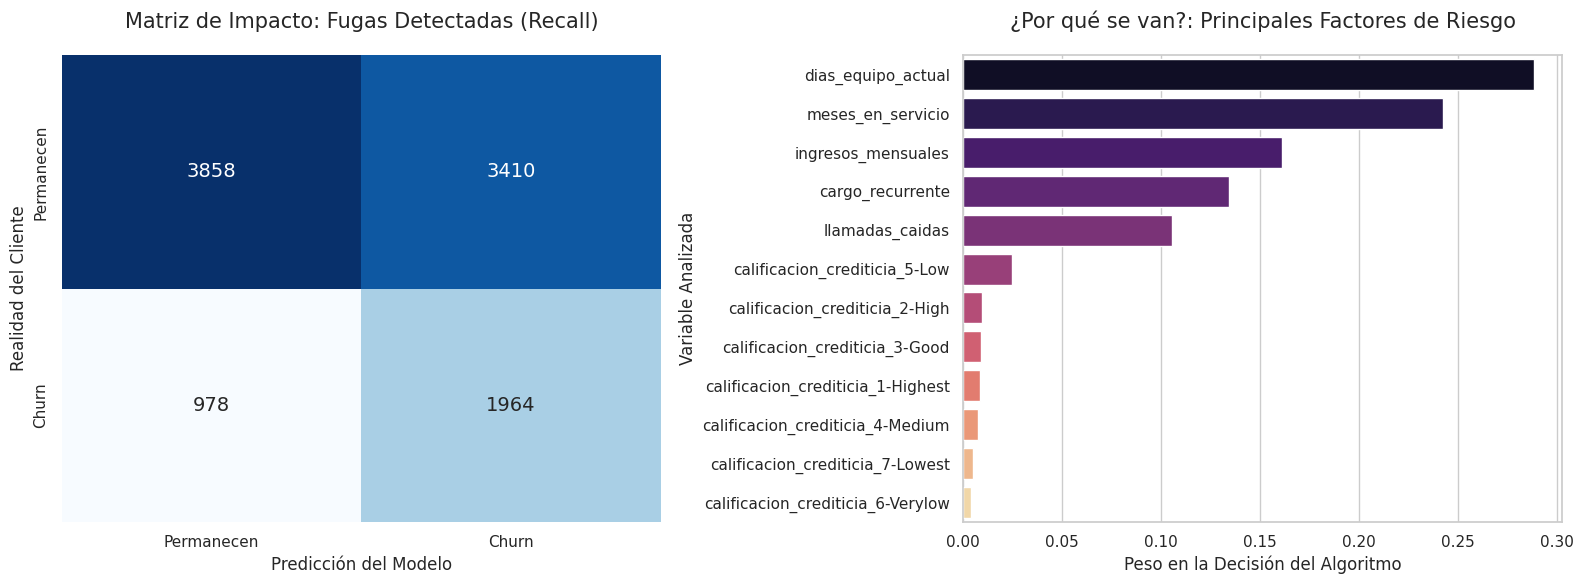

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# 1. Detectar el nombre de los pasos para evitar el KeyError
# Normalmente es 'clf' o 'classifier'
step_model_name = contrato_final.steps[-1][0]
step_prepro_name = contrato_final.steps[0][0]

# Configuramos el estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))

# --- GRÁFICA 1: Matriz de Confusión (Impacto de Negocio) ---
plt.subplot(1, 2, 1)
y_pred = contrato_final.predict(X_test[cols_model_6])
cm = confusion_matrix(y_test, y_pred)

# Visualización con anotaciones claras
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Permanecen', 'Churn'],
            yticklabels=['Permanecen', 'Churn'],
            annot_kws={"size": 14})

plt.title('Matriz de Impacto: Fugas Detectadas (Recall)', fontsize=15, pad=20)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Realidad del Cliente', fontsize=12)

# --- GRÁFICA 2: Importancia de Variables (Factores de Riesgo) ---
plt.subplot(1, 2, 2)

# Acceso dinámico al clasificador y al preprocesador
importancias = contrato_final.named_steps[step_model_name].feature_importances_
nombres = contrato_final.named_steps[step_prepro_name].get_feature_names_out()

# Limpiamos nombres
nombres_limpios = [n.split('__')[-1] for n in nombres]

# Crear DataFrame y ordenar
df_imp = pd.DataFrame({'Variable': nombres_limpios, 'Importancia': importancias})
df_imp = df_imp.sort_values(by='Importancia', ascending=False)

# Línea corregida para evitar el FutureWarning:
# Asignamos 'Variable' a 'hue' y desactivamos la leyenda
sns.barplot(data=df_imp, x='Importancia', y='Variable', hue='Variable', palette='magma', legend=False)

plt.title('¿Por qué se van?: Principales Factores de Riesgo', fontsize=15, pad=20)
plt.xlabel('Peso en la Decisión del Algoritmo', fontsize=12)
plt.ylabel('Variable Analizada', fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
# Ver el promedio de cancelación por grupo de crédito
# Si el número es cercano a 1, ese grupo es de alto riesgo
print(df.groupby('grupo_ingresos')['churn_bin'].mean())

grupo_ingresos
0    0.302298
1    0.291319
2    0.296327
3    0.263123
4    0.276585
5    0.282731
6    0.283543
7    0.297941
8    0.276506
9    0.282042
Name: churn_bin, dtype: float64


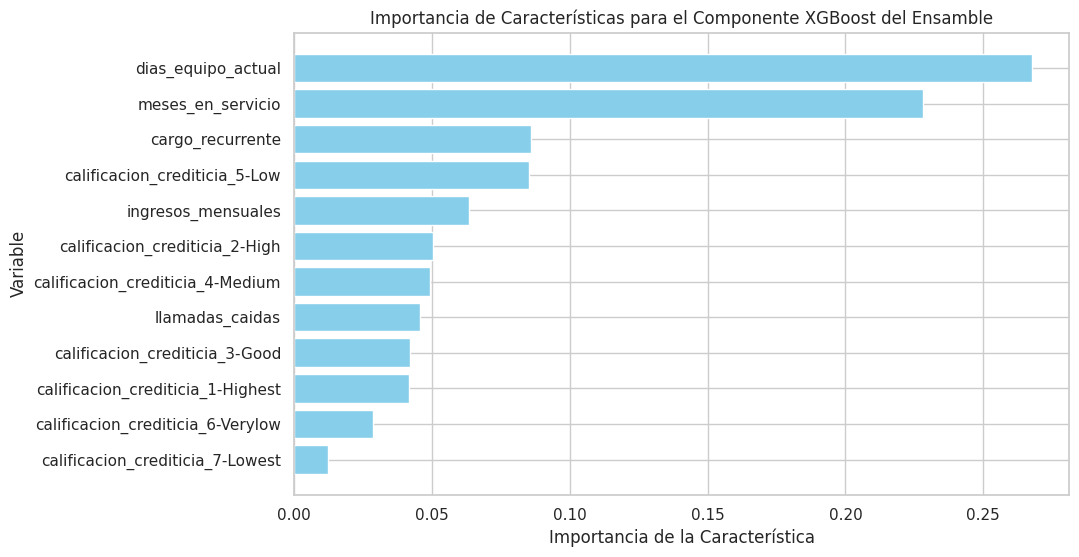

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Ver importancia de las variables para el componente XGBoost del Ensamble
# Accedemos al clasificador XGBoost dentro del pipeline del modelo de ensamble.
# Primero, accedemos al VotingClassifier ('clf') y luego al estimador 'xgb' dentro de él.
importancias = modelo_final_produccion.named_steps['clf'].named_estimators_['xgb'].feature_importances_

# Obtener los nombres de las características después del preprocesamiento
# Accedemos al preprocesador y luego usamos get_feature_names_out()
feature_names_transformed = modelo_final_produccion.named_steps['pre'].get_feature_names_out()

# Para mayor claridad, podemos limpiar los prefijos 'num__' y 'cat__' de los nombres
cleaned_feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names_transformed]

# Asegurarse de que las importancias y los nombres coincidan en longitud
if len(cleaned_feature_names) != len(importancias):
    print("Advertencia: El número de nombres de características transformadas no coincide con el número de importancias.")
    # Esto no debería ocurrir si get_feature_names_out() funciona como se espera.

# Crear un DataFrame para facilitar la visualización y ordenamiento
df_importances_xgb = pd.DataFrame({
    'Feature': cleaned_feature_names,
    'Importance': importancias
})
df_importances_xgb = df_importances_xgb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df_importances_xgb['Feature'], df_importances_xgb['Importance'], color='skyblue')
plt.xlabel("Importancia de la Característica")
plt.ylabel("Variable")
plt.title("Importancia de Características para el Componente XGBoost del Ensamble")
plt.gca().invert_yaxis() # Opcional: para que la característica más importante esté arriba
plt.show()

In [38]:
print("Tabla de Importancia de Características para XGBoost (Ensamble):")
display(df_importances_xgb)

Tabla de Importancia de Características para XGBoost (Ensamble):


,Feature,Importance
4,dias_equipo_actual,0.267850
3,meses_en_servicio,0.228038
1,cargo_recurrente,0.085924
9,calificacion_crediticia_5-Low,0.085252
0,ingresos_mensuales,0.063431
6,calificacion_crediticia_2-High,0.050378
8,calificacion_crediticia_4-Medium,0.049195
2,llamadas_caidas,0.045501
7,calificacion_crediticia_3-Good,0.042118
5,calificacion_crediticia_1-Highest,0.041661
